In [1]:
import sys
sys.path.append('/kaggle/input/alexnet/pytorch/baseline/1')
import torch
import torch.nn as nn
from torchvision import datasets
from baseline.model import AlexNetBaseline, init_params
from baseline.dataset_preparation import indices_split
from baseline.data_transforms import prepreprocess, get_preprocess, get_train_augment
from baseline.train import train
import matplotlib.pyplot as plt
from baseline.eval import accuracy, topk 

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
preprocess = get_preprocess(datasets.CIFAR10(
    'datasets/cifar10', train=True, download=True, transform=prepreprocess))
cv_dataset = datasets.CIFAR10(
    'datasets/cifar10', train=True, transform=preprocess)
train_augment = get_train_augment(cv_dataset)
train_dataset = datasets.CIFAR10(
    'datasets/cifar10', train=True, transform=train_augment)
test_dataset = datasets.CIFAR10(
    'datasets/cifar10', train=False,transform=preprocess)

cv_indices, train_indices = indices_split(len(train_dataset), ratio=0.2)
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
cv_dataset = torch.utils.data.Subset(cv_dataset, cv_indices)

print(f'Train: {len(train_dataset)}')
print(f'Cross Validation: {len(cv_dataset)}')
print(f'Test: {len(test_dataset)}')

100%|██████████| 170498071/170498071 [00:08<00:00, 20622726.60it/s]


Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Mean: [125.35567474365234, 122.99826049804688, 113.91352844238281]
Covar: tensor([[3779.5000, 3389.7288, 3134.5535],
        [3389.7288, 3672.3616, 3586.9302],
        [3134.5535, 3586.9302, 4270.4468]], device='cuda:0')
Eigen values (sqrt): tensor([[ 13.5105],
        [ 29.7229],
        [103.2295]])
Eigen vectors: tensor([[-0.4367, -0.7066,  0.5568],
        [ 0.8152, -0.0491,  0.5771],
        [-0.3804,  0.7059,  0.5975]])
Train: 40000
Cross Validation: 10000
Test: 10000


In [4]:
model = AlexNetBaseline(len(test_dataset.classes))
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    model = nn.DataParallel(model)
model.to(device)
init_params(model)
compiled_model = model
# if torch.cuda.is_available():
#     compiled_model = torch.compile(model)

In [5]:
costs, cv_error_rates, learning_rates = train(
    compiled_model,
    train_dataset=train_dataset,
    cv_dataset=cv_dataset,
    batch_size=128,
    num_epochs=90,
    initial_lr=0.01,
    num_workers=3
)

Epoch 1/90, Cost: 2.262, CV_Error: 81.78%, lr: 0.01, Time: 91.48774480819702
Epoch 2/90, Cost: 2.204, CV_Error: 89.33%, lr: 0.01, Time: 92.74024510383606
Epoch 3/90, Cost: 2.179, CV_Error: 85.41%, lr: 0.01, Time: 92.62007641792297
Epoch 4/90, Cost: 2.148, CV_Error: 78.72%, lr: 0.01, Time: 92.71078848838806
Epoch 5/90, Cost: 2.121, CV_Error: 81.66%, lr: 0.01, Time: 93.0796217918396
Epoch 6/90, Cost: 2.110, CV_Error: 79.53%, lr: 0.01, Time: 92.30827212333679
Epoch 7/90, Cost: 2.097, CV_Error: 80.70%, lr: 0.01, Time: 92.47756743431091
Epoch 8/90, Cost: 2.066, CV_Error: 83.38%, lr: 0.01, Time: 92.45395731925964
Epoch 9/90, Cost: 2.088, CV_Error: 83.27%, lr: 0.01, Time: 92.26965761184692
Epoch 10/90, Cost: 2.074, CV_Error: 79.38%, lr: 0.01, Time: 92.39546489715576
Epoch 11/90, Cost: 2.088, CV_Error: 79.75%, lr: 0.01, Time: 91.84894871711731
Epoch 12/90, Cost: 2.334, CV_Error: 89.84%, lr: 0.01, Time: 92.19320344924927
Epoch 13/90, Cost: 2.362, CV_Error: 89.84%, lr: 0.01, Time: 91.16723537445

In [6]:
torch.save(model.state_dict(), 'baseline_cifar10.model.pt')
torch.save(preprocess.state_dict(), 'baseline_cifar10.preprocess.pt')
torch.save(train_augment.state_dict(), 'baseline_cifar10.train_augment.pt')

In [7]:
top1 = accuracy(compiled_model, test_dataset)
top3 = topk(compiled_model, test_dataset, k=3)
print('Top 1: {top1}')
print('Top 3: {top3}')

Top 1: {top1}
Top 3: {top3}


Text(0.5, 1.0, 'Costs')

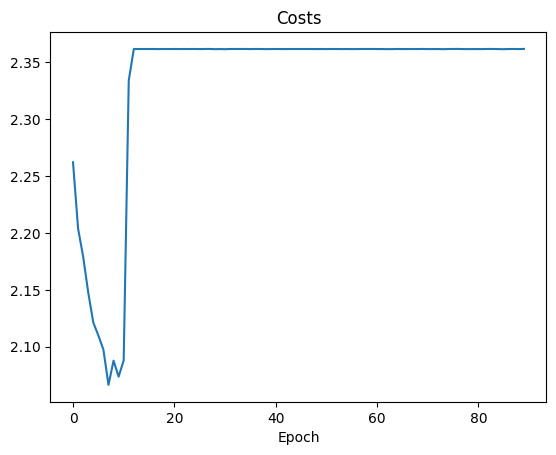

In [8]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.title('Costs')

Text(0.5, 1.0, 'Cross Validation Error Rates')

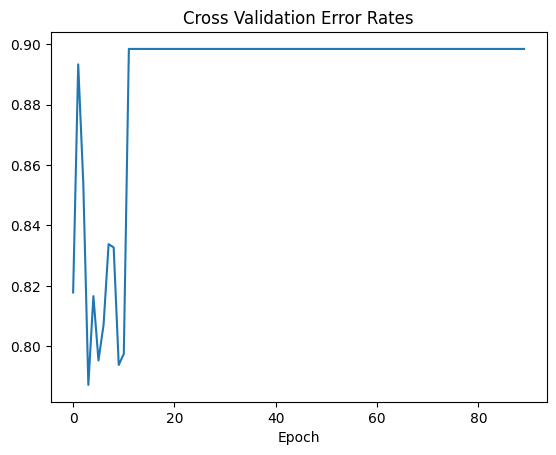

In [9]:
plt.plot(cv_error_rates)
plt.xlabel("Epoch")
plt.title('Cross Validation Error Rates')

Text(0.5, 1.0, 'Learning Rates')

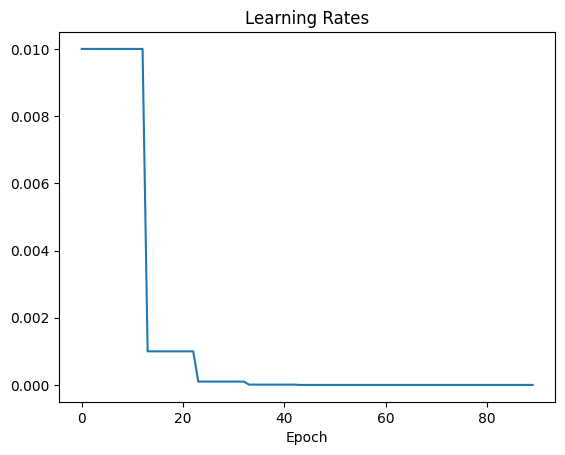

In [10]:
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.title('Learning Rates')